In [1]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt

import random

from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from scipy.optimize import minimize
from itertools import combinations

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit_optimization.algorithms import MinimumEigenOptimizer

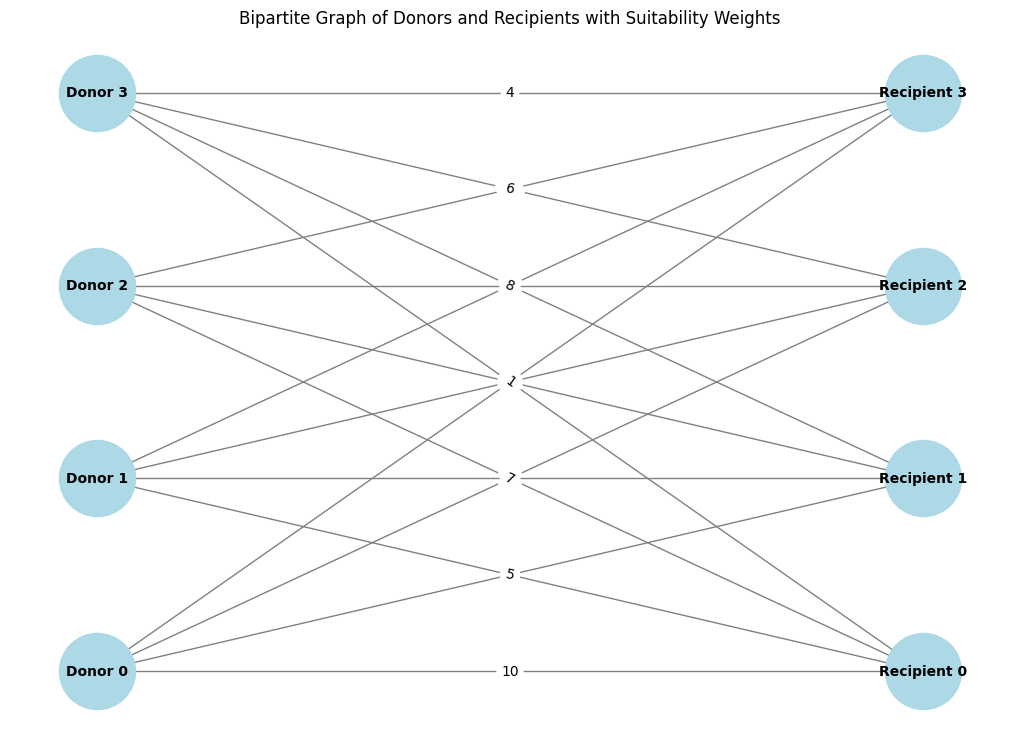

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization import QuadraticProgram

# Define the problem
n_donors = 4  # Number of donors
n_recipients = 4  # Number of recipients
weights = [
    [10, 2, 1, 8],  # Donor 0
    [5, 9, 4, 6],   # Donor 1
    [7, 3, 2, 10],  # Donor 2
    [1, 8, 6, 4]    # Donor 3
]  # Example weights

# Initialize QUBO
qubo = QuadraticProgram()

# Add binary variables for each pair (donor, recipient)
for i in range(n_donors):
    for j in range(n_recipients):
        qubo.binary_var(name=f"x_{i}_{j}")

# Set the objective function (maximize total suitability)
objective_terms = []
for i in range(n_donors):
    for j in range(n_recipients):
        objective_terms.append(weights[i][j])

# The objective should be a weighted sum of all pairwise terms
qubo.maximize(linear={f"x_{i}_{j}": weights[i][j] for i in range(n_donors) for j in range(n_recipients)})

# Create a bipartite graph for visualization
G = nx.Graph()

# Add nodes for donors and recipients
donor_nodes = [f"Donor {i}" for i in range(n_donors)]
recipient_nodes = [f"Recipient {j}" for j in range(n_recipients)]
G.add_nodes_from(donor_nodes, bipartite=0)
G.add_nodes_from(recipient_nodes, bipartite=1)

# Add weighted edges between donors and recipients
for i in range(n_donors):
    for j in range(n_recipients):
        G.add_edge(donor_nodes[i], recipient_nodes[j], weight=weights[i][j])

# Draw the bipartite graph
pos = nx.bipartite_layout(G, nodes=donor_nodes)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Bipartite Graph of Donors and Recipients with Suitability Weights")
plt.show()

In [3]:
# Add constraints for donors (each donor must match with one recipient)
for i in range(n_donors):
    qubo.linear_constraint(linear={f"x_{i}_{j}": 1 for j in range(n_recipients)}, sense='==', rhs=1, name=f"donor_{i}")

# Add constraints for recipients (each recipient must match with one donor)
for j in range(n_recipients):
    qubo.linear_constraint(linear={f"x_{i}_{j}": 1 for i in range(n_donors)}, sense='==', rhs=1, name=f"recipient_{j}")


In [31]:
backend = AerSimulator(max_parallel_shots=1)

# Set up the optimizer
optimizer = COBYLA()
sampler = Sampler()

# Set up the QAOA with the Estimator primitive
estimator = Estimator()
qaoa = QAOA(optimizer=optimizer, reps=1, sampler=sampler) 

# Use Minimum Eigen Optimizer to solve the QUBO
minimum_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = minimum_eigen_optimizer.solve(qubo)

# Extract results
print("Solution:", result)
print("Objective value:", result.fval)

# Print matched pairs
for i in range(n_donors):
    for j in range(n_recipients):
        if result.x[i * n_recipients + j] > 0.5:
            print(f"Donor {i} matched with Recipient {j}")

C:\Users\asus\AppData\Local\Temp\ipykernel_29396\3814364655.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\asus\AppData\Local\Temp\ipykernel_29396\3814364655.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Solution: fval=35.0, x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, x_3_3=0.0, status=SUCCESS
Objective value: 35.0
Donor 0 matched with Recipient 0
Donor 1 matched with Recipient 1
Donor 2 matched with Recipient 3
Donor 3 matched with Recipient 2
